# Credit Scoring

**Analysis goals**:
- Find out whether the marital status and the number of children affect the fact of repaying the loan on time.

Input data: clients' solvency statistics from the bank.  
Output data will be taken into account when building a credit scoring model.

**Analysis structure**:
* Data overview
* Data preparation
* Hypothesis check

## Data overview

In [25]:
import pandas as pd

In [26]:
df = pd.read_csv('data.csv')

In [27]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


There are 11 columns in the table:

`children` — number of kids in the family; data type `int`  
`days_employed` — number of days employed; data type `float`  
`dob_years` — client's age in years; data type `int`  
`education` — client's level of education; data type `object`  
`education_id` — education identification; data type `int`  
`family_status` — client's family status; data type `object`  
`family_status_id` — family status identification; data type `int`  
`gender` — client's gender; data type `object`  
`income_type` — client's income type; data type `object`  
`debt` — whether missed debt payments previously; data type `int`  
`total_income` — client's total monthly income; data type `float`  
`purpose` — client's credit purpose; data type `object`  


- Non-null count for columns is different, so there are missing values in `days_employed` and `total_income` data.
- Some of the data entries in `days_employed` are negative and some are way too high, which is strange and needs to be analysed in details.
- There are definetely implicit duplicates regarding register in `education` which needs to be fixed.
- Data in `purpose` also has implicit duplicates as it was filled in a free form.

## Data preparation

### Missing values in data

We start with missing values in `total_income`. Let's first understand the proportion of missed data and then fix it.

In [29]:
df['total_income'].isna().mean()

0.10099883855981417

Missing values are in around 10% of the cases - it is significant number. Most probably people when filling the form just omitted the field.  
We fill the missing values with the median from each income type in order to exclude data outliers.

In [30]:
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform("median"))

### Anomalies

Let's check for some anomalies in data and fix it if needed.

**Children**

In [31]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

It is very strange to see that there can be `-1` and `20` children.  
Assumptions:
* In `-1` case the mistake was that it included the dash, so will turn this into `1`
* In `20` case the mistake was that it was intended to be `2`, so will turn this into `2` 

In [32]:
df.loc[df['children'] == -1, 'children'] = 1
df.loc[df['children'] == 20, 'children'] = 2

**Days employed**

In [33]:
df[df['days_employed'] < 0]['days_employed'].count() / df['days_employed'].count()

0.8219730246498889

More than 80% of all the values are negative which is definetely an anomaly.

<AxesSubplot:ylabel='Frequency'>

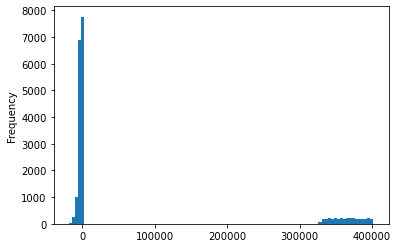

In [34]:
df['days_employed'].plot.hist(bins=100)

It is very clear on the histagram that there are only negative and way too big positive values (which are impossible to be: let's assume the maximum working period could be around 50 years, so it would be 50 years times 365 days = around 18k days only but not more than 400k).  
  
Let's have a deeper look into histagrams.

<AxesSubplot:ylabel='Frequency'>

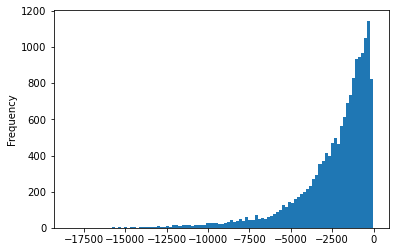

In [36]:
df[df['days_employed'] < 0]['days_employed'].plot.hist(bins=100)

Negative part looks ok in terms of the numbers (max is around 17k) and distribution.

<AxesSubplot:ylabel='Frequency'>

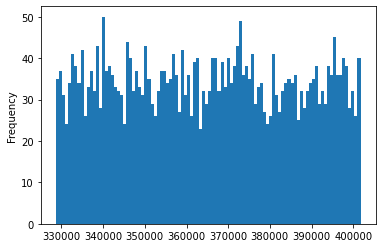

In [37]:
df[df['days_employed'] > 0]['days_employed'].plot.hist(bins=100)

Positive part is very anomal both in terms of the numbers and distribution.

Let's fix the anomalies.

Assumptions:  
* For negative values, we suppose the mistake is that includes the dash from the form, which here turned to be minus. So we turn all the negative values into positive.
* For positive values, we suppose there is a technical mistake. So we apply the median for those ones. 
* Moreover, we apply medians for each income type for all the missing data in `days_employed` as well

In [38]:
days_employed_median = abs(int(df[df['days_employed'] < 0]['days_employed'].median()))

In [39]:
df['days_employed'] = df['days_employed'].apply(lambda x: days_employed_median if (x > 0) else abs(x))

In [40]:
df['days_employed'] = df['days_employed'].fillna(df.groupby('income_type')['days_employed'].transform('median'))

<AxesSubplot:ylabel='Frequency'>

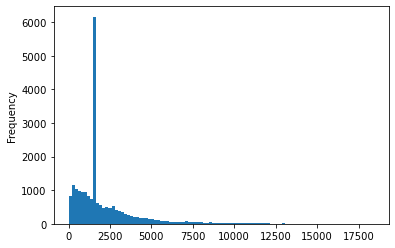

In [41]:
df['days_employed'].plot.hist(bins=100)

The histogram now looks way less normal than for negative side two steps before but that is the only way we can work it out now.  
We defenitely need to discuss these data entries with the developers to see how to fix it.

**Total income**

We bring `days_employed` and `total_income` to datatype `int` as those values should not be floats.

In [42]:
df['days_employed'] = df['days_employed'].astype(int)
df['total_income'] = df['total_income'].astype(int)

**Gender**

In [44]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [45]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


There is one anomaly in `gender` which can not be attributed to either type so we drop this line and reset index.

In [46]:
df = df.drop(index=10701).reset_index(drop=True)

### Duplicates in data

**Education**

There are implicit duplicates regarding register in `education` which needs to be fixed. We simply get all the data into lower register.

In [47]:
df['education'] = df['education'].str.lower()

In [48]:
df.groupby('education')['education_id'].unique().sort_values()

education
высшее                 [0]
среднее                [1]
неоконченное высшее    [2]
начальное              [3]
ученая степень         [4]
Name: education_id, dtype: object

Checking the results, we see that there are no more implicit duplicates in `education`.  
Moreover, each level of education in `education` has one and only `education_id`.

**Family status**

There can also be implicit duplicates in `family_status`, let's check it.

In [49]:
df.groupby('family_status')['family_status_id'].unique().sort_values()

family_status
женат / замужем          [0]
гражданский брак         [1]
вдовец / вдова           [2]
в разводе                [3]
Не женат / не замужем    [4]
Name: family_status_id, dtype: object

It's all good here - no duplicates. Moreover, each family status has one and only family status id.

**Income type**

In [50]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

It's also all good with `income_type` - no duplicates.

**Credit purpose**

In [51]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Data in `purpose` also has implicit duplicates as it seems it was filled in a free form.  
Data can be grouped into 4 categories regarding:
- car
- real estate 
- marriage
- education

In order to do it correctly, we create a function that will group each subcategory into a bigger category.

In [52]:
def purpose_group(purpose):
        if 'авто' in purpose:
            return 'операции с автомобилем'
        elif 'жиль' in purpose:
            return 'операции с недвижимостью'
        elif 'едвижим' in purpose:
            return 'операции с недвижимостью'    
        elif 'вадьб' in purpose:
            return 'проведение свадьбы'
        elif 'бразован' in purpose:
            return 'получение образования'   
        else: return 'осталось без категории, проверь вординг'

In [53]:
df['purpose_category'] = df['purpose'].apply(purpose_group)

In [54]:
df['purpose_category'].unique()

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

The function works perfectly - all the subcategories are grouped as wanted.

**General duplicates**

We check for all other duplicates overall and delete if there are some.

In [55]:
df.duplicated().sum()

71

In [56]:
df = df.drop_duplicates().reset_index(drop=True)

### Creating new dataframes

Creating new dataframes from the main one regarding education and family identifications.

In [57]:
education_df = df[['education', 'education_id']]
education_df = education_df.drop_duplicates().reset_index(drop=True)

In [58]:
family_df = df[['family_status', 'family_status_id']]
family_df = family_df.drop_duplicates().reset_index(drop=True)

Deleting `education` and `family_status` from the main dataframe.

In [59]:
df = df.drop(['education', 'family_status'], axis=1)

### Creating new income categories

We range income categories based on `total_income` with the help of new function. There are 5 groups in total.

In [60]:
def income_category(income):
        if income <= 30000:
            return 'E'
        if income <= 50000:
            return 'D'
        if income <= 200000:
            return 'C'
        if income <= 1000000:
            return 'B'
        elif income > 1000000:
            return 'A'
        else: return 'check the numbers'

In [61]:
df['total_income_category'] = df['total_income'].apply(income_category)

In [62]:
df['total_income_category'].unique()

array(['B', 'C', 'D', 'E', 'A'], dtype=object)

## Hypothesis check

The main goal is to find out what affects the fact of repaying the loan on time.

We check this from 7 different angles:
* Children and indebtness
* Family status and indebtness
* Level of income and indebtness
* Purpose of credit and indebtness
* Age group and indebtness
* Income type and indebtness
* Education and indebtness

### Children and indebtness

In [63]:
df.pivot_table(index=['children'], 
               values=['debt'], 
               aggfunc=('sum', 'count', 'mean')
              )

debt                  
            count      mean     sum
children                           
0         14090.0  0.075444  1063.0
1          4855.0  0.091658   445.0
2          2128.0  0.094925   202.0
3           330.0  0.081818    27.0
4            41.0  0.097561     4.0
5             9.0  0.000000     0.0

**Findings**

1) In general, the lower the number of children in the family, the less people don't pay their loan on time; i.e. people who do not have kids at all have the lowest indebtness ratios  
2) However, people with 3 children are outlining from the trend a bit, but not significantly  
3) People with 5 children (although small number - only 9 people) have never missed a payment on the loan

### Family status and indebtness

In [64]:
family = df.merge(family_df, on='family_status_id', how='left')

# we first get the family statuses from a separate dictionary

In [65]:
family.pivot_table(index=['family_status'], 
                   values=['debt'],
                   aggfunc=('sum', 'count', 'mean')
                  ).sort_values(by=('debt', 'mean'))

debt                 
                         count      mean    sum
family_status                                  
вдовец / вдова           959.0  0.065693   63.0
в разводе               1195.0  0.071130   85.0
женат / замужем        12339.0  0.075452  931.0
гражданский брак        4150.0  0.093494  388.0
Не женат / не замужем   2810.0  0.097509  274.0

**Findings**

1) People who lost their partners or divorced have the lowest indebtness ratios   
2) Married people are in the middle - they fail to pay on time in 7,5% of the cases  
3) Compared to married people, those in partnerships have higher rates of not paying on time  
4) The highest levels of indebtness are among single people

### Level of income and indebtness

In [66]:
income_category = {'total_income_category': ['A', 'B', 'C', 'D', 'E'],
                   'range': ['up to 30k', 'up to 50k', 'up to 200k', 'up to 1 mln', 'more than 1 mln']
                  }
income_df = pd.DataFrame(income_category)

# we create a special dictionary for income categories 
# so it is easier to analyse further in the pivot

In [67]:
income = df.merge(income_df, on='total_income_category', how='left')

In [68]:
income.pivot_table(index=['range'], 
                   values=['debt'],
                   aggfunc=('sum', 'count', 'mean')
                  ).sort_values(by=('debt', 'mean'))

debt                  
                   count      mean     sum
range                                     
up to 1 mln        350.0  0.060000    21.0
up to 50k         5041.0  0.070621   356.0
up to 30k           25.0  0.080000     2.0
up to 200k       16015.0  0.084920  1360.0
more than 1 mln     22.0  0.090909     2.0

**Findings**

1) There is no clear correlation between the level of income and indebtness  
2) People earning high income (up to 1 mln a month) have the lowest ratios while people earning the highest income (more than 1 mln a month) have the highest ratios  
3) The dependence b/w level of income and indebtness should be the most important one for the modelling however in this case the data does not provide the clear trend

### Purpose of credit and indebtness

In [69]:
df.pivot_table(index=['purpose_category'],
                   values=['debt'],
                   aggfunc=('sum', 'count', 'mean')
                   ).sort_values(by=('debt', 'mean'))

debt                 
                            count      mean    sum
purpose_category                                  
операции с недвижимостью  10810.0  0.072340  782.0
проведение свадьбы         2324.0  0.080034  186.0
получение образования      4013.0  0.092200  370.0
операции с автомобилем     4306.0  0.093590  403.0

**Findings**

1) There is not a great dispersion in rates of indebtness according to the purpose of the credit  
2) The lowest ones are with the Real Estate and the highest ones are with Car loan  
3) It could be expected that people fail the highest (compared to RE and car loans) to pay on the loans for marriages and education, however the data does not prove it


### Age group and indebtness

First we create a function that groups people according to the age and then we analyse it in detail.

In [70]:
def age_group(age):
        if age < 30:
            return 'under 30'
        if age < 45:
            return 'under 45'
        if age < 60:
            return 'under 60'
        if age < 75:
            return 'under 75'
        elif age >= 75:
            return 'more than 75'
        else: return 'check the numbers'

In [71]:
df['age_group'] = df['dob_years'].apply(age_group)

In [72]:
df['age_group'].unique()

array(['under 45', 'under 60', 'under 30', 'under 75', 'more than 75'],
      dtype=object)

In [73]:
df.pivot_table(index=['age_group'],
                   values=['debt'],
                   aggfunc=('sum', 'count', 'mean')
                   ).sort_values(by=('debt', 'mean'))

debt                 
               count      mean    sum
age_group                            
more than 75     1.0  0.000000    0.0
under 75      2499.0  0.049220  123.0
under 60      7146.0  0.067870  485.0
under 45      8527.0  0.091005  776.0
under 30      3280.0  0.108841  357.0

**Findings**

1) Here is the clear dependence between the age group and indebtness  
2) The younger the people, the more often they fail on paying loans on time  
3) People under the age of 30 have the highest rates of almost 11%


### Income type and indebtness

In [74]:
df.pivot_table(index=['income_type'],
                   values=['debt'],
                   aggfunc=('sum', 'count', 'mean')
                   ).sort_values(by=('debt', 'mean'))

debt                  
                   count      mean     sum
income_type                               
предприниматель      2.0  0.000000     0.0
студент              1.0  0.000000     0.0
пенсионер         3829.0  0.056412   216.0
госслужащий       1457.0  0.059025    86.0
компаньон         5077.0  0.074059   376.0
сотрудник        11084.0  0.095724  1061.0
безработный          2.0  0.500000     1.0
в декрете            1.0  1.000000     1.0

**Findings**

1) Here is a pretty clear dependence between the income type and indebtness  
2) Pensioners and people in the public sector have, as expected, the lowest rates of not paying on time  
3) People on maternity leave and jobless have the highest rates of failing to pay a loan on time (although the sample is small)  
4) Students and businessmen have the rate of 0 although again the sample is small

### Education and indebtness

In [75]:
education = df.merge(education_df, on='education_id', how='left')

# we first get the family statuses from a separate dictionary

In [76]:
education.pivot_table(index=['education'],
               values=['debt'],
               aggfunc=('sum', 'count', 'mean')
               ).sort_values(by=('debt', 'mean'))

debt                  
                       count      mean     sum
education                                     
ученая степень           6.0  0.000000     0.0
высшее                5250.0  0.052952   278.0
среднее              15172.0  0.089902  1364.0
неоконченное высшее    743.0  0.091521    68.0
начальное              282.0  0.109929    31.0

**Findings**

1) The dependence between education and indebtness is pretty clear: the higher is the education level, the less people fail on repaying the loan on time  
2) The only outlier is the `неоконченное высшее` as according to basic expectations it should have the lower ratio than for the `среднее` one 

# Research results

We have analysed the data in detail and tested 7 dependencies. Here are the outcomes:

* Children: People with no kids fail on paying the loan on time less often that people with children  
* Family status: People who lost their partners or divorced have way lower indebtness ratios than single people  
* Income level: There is no clear correlation between the level of income and indebtness: people earning the most have the highest levels of failing to pay on time, which is counter intuitive  
* Credit purpose: People with mortgages/real estate connected loans fail the lowest; people having car loans - the highest  
* Age group: The younger the people, the more often they fail on paying loans on time  
* Income type: Pensioners and people in the public sector have, as expected, the lowest rates of not paying on time
* Education: The dependence between education and indebtness is pretty clear: the higher is the education level, the less people fail on repaying the loan on time